In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelBinarizer
from torchvision.io import read_image
from torchvision import models
import os
import glob
import random
import pandas as pd
import seaborn as sn
from cloudnet import *
from casv3 import *
from early_stopping import *
import albumentations as A
from albumentations.pytorch import ToTensorV2
import copy
from tqdm import tqdm
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

In [5]:
torch.cuda.is_available()

True

In [6]:
device = torch.device('cuda:3' if torch.cuda.is_available() else 'cpu')

In [7]:
device

device(type='cuda', index=3)

In [5]:
import wandb
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: mario-andonaire (use `wandb login --relogin` to force relogin)


True

In [6]:
config={
    "learning_rate": 0.0003,
    "architecture": "Inceptionv3",
    "dataset": "CAS_10c_f",
    "epochs": 40,
    "batch_size": 4,
    "reduce_factor": 10,
    "print_epochs": 5,
    "print_times_per_epoch":20,
    "reduce_epochs": 2000,
    "optimizer": "Adam"
}

In [7]:
wandb.init(
  # Set the project where this run will be logged
  project="cloud-classification", 
  # We pass a run name (otherwise it’ll be randomly assigned, like sunshine-lollypop-10)
  name=f"experiment_{config['architecture']}_{config['dataset']}", 
  # Track hyperparameters and run metadata
  config=config)

In [8]:
""" Load pretrained model """
model = models.inception_v3(pretrained=True)
in_ftrs = model.fc.in_features
model.fc = nn.Linear(in_ftrs, CAS.get_n_classes())
in_ftrs = model.AuxLogits.fc.in_features
model.AuxLogits.fc = nn.Linear(in_ftrs, CAS.get_n_classes())
#model.load_state_dict(torch.load('./resnet50HBMCD.pth'))

In [9]:
model = model.to(device)
wandb.watch(model)

[]

In [8]:
input_size = 299
train_transform = A.Compose(
    [
        A.SmallestMaxSize(max_size=320),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
        A.RandomCrop(height=input_size, width=input_size),
        A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)
validation_transform = A.Compose(
    [
        A.Resize (height=input_size, width=input_size),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)

In [9]:
train_data = CAS(transform=train_transform, data_path='/data/mandonaire/Cloudappreciationsociety/filtered_images_data_aug/train.csv')
validation_data = CAS(transform=validation_transform, data_path='/data/mandonaire/Cloudappreciationsociety/filtered_images_data_aug/validation.csv')

In [10]:
len(train_data)

10004

In [13]:
def visualize_augmentations(dataset, idx=0, samples=10, cols=5):
    dataset = copy.deepcopy(dataset)
    dataset.transform = A.Compose([t for t in dataset.transform if not isinstance(t, (A.Normalize, ToTensorV2))])
    rows = samples // cols
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 6))
    for i in range(samples):
        image, _ = dataset[idx]
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_axis_off()
    plt.tight_layout()
    plt.show()

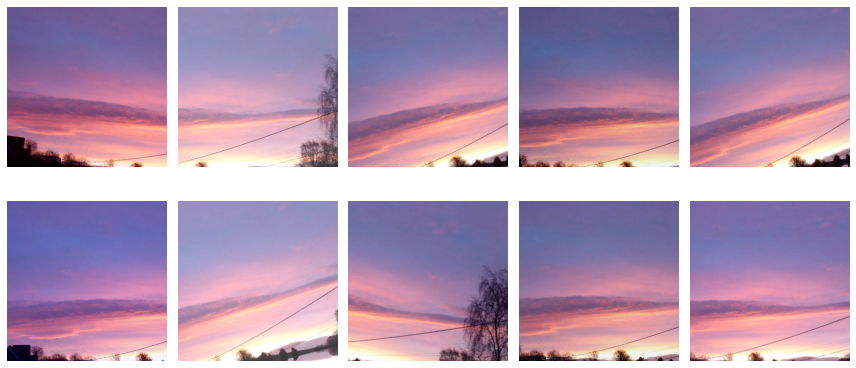

In [14]:
random.seed(42)
visualize_augmentations(train_data, samples=10, idx=150)

In [15]:
train_loader = DataLoader(train_data, batch_size=config["batch_size"], shuffle=True, pin_memory=True)
validation_loader = DataLoader(validation_data, batch_size=12, shuffle=False, pin_memory=True)

In [16]:
n_total_steps = len(train_loader)
n_total_steps

2501

In [17]:
learning_rate = config["learning_rate"]
num_epochs = config["epochs"]
reduce_factor = config["reduce_factor"]
print_epochs = config["print_epochs"] # 5
reduce_epochs = config["reduce_epochs"] # 20
batch_size = config["batch_size"]
print_times_per_epoch = config["print_times_per_epoch"]
running_loss = 0.0
running_correct = 0
criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

  5%|▍         | 124/2501 [00:11<03:26, 11.51it/s]

Epoch [1/40], Step [124/2501], Loss: 2.3683


 10%|▉         | 248/2501 [00:22<03:14, 11.55it/s]

Epoch [1/40], Step [248/2501], Loss: 2.2231


 15%|█▍        | 372/2501 [00:34<03:10, 11.16it/s]

Epoch [1/40], Step [372/2501], Loss: 2.2405


 20%|█▉        | 496/2501 [00:45<03:09, 10.61it/s]

Epoch [1/40], Step [496/2501], Loss: 2.1748


 25%|██▍       | 619/2501 [00:56<02:47, 11.20it/s]

Epoch [1/40], Step [620/2501], Loss: 4.0091


 30%|██▉       | 745/2501 [01:08<02:44, 10.68it/s]

Epoch [1/40], Step [744/2501], Loss: 1.5094


 35%|███▍      | 868/2501 [01:20<02:40, 10.16it/s]

Epoch [1/40], Step [868/2501], Loss: 4.5312


 40%|███▉      | 992/2501 [01:31<02:30, 10.05it/s]

Epoch [1/40], Step [992/2501], Loss: 1.7983


 45%|████▍     | 1116/2501 [01:42<02:04, 11.14it/s]

Epoch [1/40], Step [1116/2501], Loss: 2.6037


 50%|████▉     | 1240/2501 [01:54<01:50, 11.46it/s]

Epoch [1/40], Step [1240/2501], Loss: 2.1043


 55%|█████▍    | 1364/2501 [02:05<01:33, 12.16it/s]

Epoch [1/40], Step [1364/2501], Loss: 1.6651


 59%|█████▉    | 1488/2501 [02:17<01:26, 11.69it/s]

Epoch [1/40], Step [1488/2501], Loss: 2.7298


 64%|██████▍   | 1612/2501 [02:28<01:18, 11.30it/s]

Epoch [1/40], Step [1612/2501], Loss: 3.6821


 69%|██████▉   | 1736/2501 [02:39<01:06, 11.47it/s]

Epoch [1/40], Step [1736/2501], Loss: 2.7233


 74%|███████▍  | 1860/2501 [02:51<00:57, 11.10it/s]

Epoch [1/40], Step [1860/2501], Loss: 2.2494


 79%|███████▉  | 1984/2501 [03:02<00:49, 10.49it/s]

Epoch [1/40], Step [1984/2501], Loss: 2.1722


 84%|████████▍ | 2108/2501 [03:13<00:35, 10.98it/s]

Epoch [1/40], Step [2108/2501], Loss: 2.6392


 89%|████████▉ | 2232/2501 [03:25<00:24, 10.95it/s]

Epoch [1/40], Step [2232/2501], Loss: 1.6178


 94%|█████████▍| 2356/2501 [03:36<00:13, 10.60it/s]

Epoch [1/40], Step [2356/2501], Loss: 1.3844


 99%|█████████▉| 2480/2501 [03:47<00:01, 10.67it/s]

Epoch [1/40], Step [2480/2501], Loss: 2.1849


100%|██████████| 2501/2501 [03:49<00:00, 10.89it/s]


Epoch [2/40], Step [124/2501], Loss: 3.0633
Epoch [2/40], Step [248/2501], Loss: 2.6270
Epoch [2/40], Step [372/2501], Loss: 4.6671
Epoch [2/40], Step [496/2501], Loss: 2.8144
Epoch [2/40], Step [620/2501], Loss: 1.1654
Epoch [2/40], Step [744/2501], Loss: 2.6895
Epoch [2/40], Step [868/2501], Loss: 1.1487
Epoch [2/40], Step [992/2501], Loss: 1.6053
Epoch [2/40], Step [1116/2501], Loss: 3.2911
Epoch [2/40], Step [1240/2501], Loss: 3.5822
Epoch [2/40], Step [1364/2501], Loss: 1.8449
Epoch [2/40], Step [1488/2501], Loss: 1.7252
Epoch [2/40], Step [1612/2501], Loss: 2.2707
Epoch [2/40], Step [1736/2501], Loss: 1.4332
Epoch [2/40], Step [1860/2501], Loss: 2.9633
Epoch [2/40], Step [1984/2501], Loss: 1.4430
Epoch [2/40], Step [2108/2501], Loss: 2.2095
Epoch [2/40], Step [2232/2501], Loss: 2.0058
Epoch [2/40], Step [2356/2501], Loss: 1.1794
Epoch [2/40], Step [2480/2501], Loss: 2.5811
Epoch [3/40], Step [124/2501], Loss: 1.4204
Epoch [3/40], Step [248/2501], Loss: 3.6990
Epoch [3/40], Step [

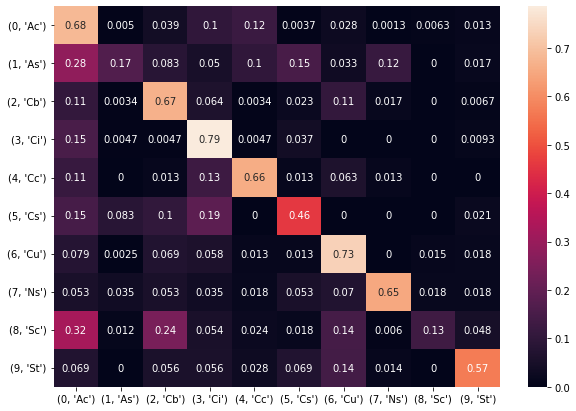

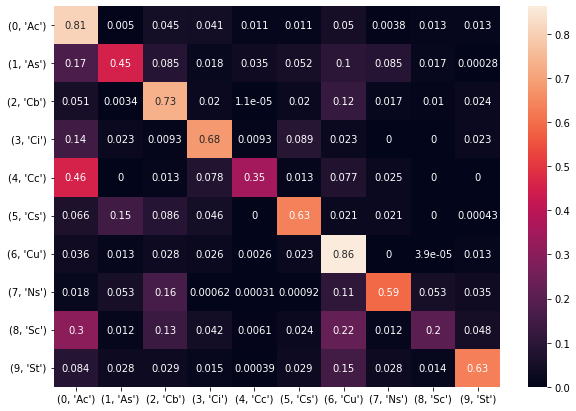

In [18]:
classes = train_data.classes
matrix = np.zeros((len(classes), len(classes)))
batch_size_validation = 12
early_stopping = EarlyStopping(tolerance=5, min_delta=0.4)
model.train()
stream = tqdm(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(stream, start=1):
        images = images.to(device)
        labels = labels.to(device)

        outputs, aux_outputs = model(images)
        loss1 = criterion(outputs, labels)
        loss2 = criterion(aux_outputs, labels)
        loss = loss1 + 0.4*loss2


        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        running_correct += (predicted == labels).sum().item()
        if (i+1) % (n_total_steps//print_times_per_epoch - 1) == 0:
            print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')
            running_accuracy = running_correct / 100 / predicted.size(0)
            running_correct = 0
            running_loss = 0.0
            wandb.log({"loss": loss, "running_accuracy" : running_accuracy})
          
    # Print validation loss and cofusion matrix
    if (epoch+1) % print_epochs == 0  or (epoch+1) == num_epochs:
        # validation the model so far
        model.eval()  # handle drop-out/batch norm layers
        loss_validation = 0
        n_correct = 0
        n_samples = 0
        n_class_correct = [0 for i in range(len(classes))]
        n_class_samples = [0 for i in range(len(classes))]
        with torch.no_grad():
            for i, (images, labels) in enumerate(validation_loader):
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)  # only forward pass - NO gradients!!
                loss_validation += criterion(outputs, labels)
                _, predicted = torch.max(outputs, 1)
                n_samples += labels.size(0)
                n_correct += (predicted == labels).sum().item()
                for i in range(batch_size_validation):
                    try:
                        label = labels[i]
                        pred = predicted[i]
                        matrix[label][pred] += 1
                        if (label == pred):
                            n_class_correct[label] += 1
                        n_class_samples[label] += 1
                    except:
                        continue
                        
        acc = 100.0 * n_correct / n_samples
        wandb.log({"accuracy": acc})
        # total loss - divide by number of batches
        loss_validation = loss_validation / len(validation_loader)
        print (f'Epoch [{epoch+1}/{num_epochs}], Loss validation: {loss_validation:.4f}')
        wandb.log({"loss_validation": loss_validation})
        wandb.log({"delta_loss": loss_validation - loss})
        
        for i in range(len(classes)):
            acc = 100.0 * n_class_correct[i] / n_class_samples[i]
            matrix[i] = matrix[i] / n_class_samples[i]
            print(f'Accuracy of {classes[i]}: {acc} %')
        
        df_cm = pd.DataFrame(matrix, index = train_data.classes,
                          columns = train_data.classes)
        plt.figure(figsize = (10,7))
        sn.heatmap(df_cm, annot=True)
        wandb.log({"confusion_matrix": wandb.Image(plt)})
        model.train()

    # Learning rate reduction
    if (epoch+1) % reduce_epochs == 0:
        if reduce_factor:
            for g in optimizer.param_groups:
                g['lr'] = g['lr']/reduce_factor
                
    # Early stopping
    try:
        early_stopping(loss, loss_validation)
        if early_stopping.early_stop:
            print("Stopped at epoch:", epoch)
            break
    except:
        pass


    
print('Finished Training')
PATH = os.path.join(wandb.run.dir, "model.pth")
torch.save(model.state_dict(), PATH)

average accuracy of the model:  0.6972602739726027
F1 Macro:  0.6303066193397342
F1 Micro:  0.6972602739726027
Accuracy of (0, 'Ac'): 70.0 %
Accuracy of (1, 'As'): 35.0 %
Accuracy of (2, 'Cb'): 74.83221476510067 %
Accuracy of (3, 'Ci'): 79.06976744186046 %
Accuracy of (4, 'Cc'): 54.43037974683544 %
Accuracy of (5, 'Cs'): 68.75 %
Accuracy of (6, 'Cu'): 84.01015228426395 %
Accuracy of (7, 'Ns'): 68.42105263157895 %
Accuracy of (8, 'Sc'): 38.32335329341317 %
Accuracy of (9, 'St'): 59.72222222222222 %


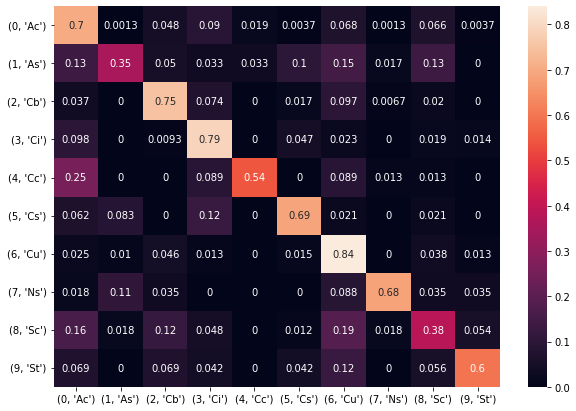

In [19]:
 # test the model so far
model.eval()  # handle drop-out/batch norm layers
loss_validation = 0
n_correct = 0
n_samples = 0
n_class_correct = [0 for i in range(len(classes))]
n_class_samples = [0 for i in range(len(classes))]
matrix = np.zeros((len(classes), len(classes)))
labels_f1 = []
predicted_f1 = []
with torch.no_grad():
    for i, (images, labels) in enumerate(validation_loader):
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)  # only forward pass - NO gradients!!
        loss_validation += criterion(outputs, labels)
        _, predicted = torch.max(outputs, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()
        labels_f1.append(labels)
        predicted_f1.append(predicted)
        for i in range(batch_size_validation):
            try:
                label = labels[i]
                pred = predicted[i]
                matrix[label][pred] += 1
                if (label == pred):
                    n_class_correct[label] += 1
                n_class_samples[label] += 1
            except:
                continue
                
predicted_f1 = torch.cat(predicted_f1).tolist()
labels_f1 = torch.cat(labels_f1).tolist()
avg_accuracy = accuracy_score(labels_f1, predicted_f1)
f1_macro = f1_score(labels_f1, predicted_f1, average="macro")
f1_micro = f1_score(labels_f1, predicted_f1, average="micro")
print("average accuracy of the model: ", avg_accuracy)
print("F1 Macro: ", f1_macro)
print("F1 Micro: ", f1_micro)
acc = 100.0 * n_correct / n_samples
wandb.log({"accuracy": acc})
wandb.log({"avg_accuracy": acc})
wandb.log({"f1_macro": f1_macro})
wandb.log({"f1_micro": f1_micro})
# total loss - divide by number of batches
loss_validation = loss_validation / len(validation_loader)
wandb.log({"loss_validation": loss_validation})
wandb.log({"delta_loss": loss_validation - loss})

for i in range(len(classes)):
    acc = 100.0 * n_class_correct[i] / n_class_samples[i]
    matrix[i] = matrix[i] / n_class_samples[i]
    print(f'Accuracy of {classes[i]}: {acc} %')

df_cm = pd.DataFrame(matrix, index = train_data.classes,
                  columns = train_data.classes)
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)
wandb.log({"confusion_matrix": wandb.Image(plt)})

In [20]:
wandb.finish()

accuracy,▁█▇
avg_accuracy,▁
delta_loss,█▁█
f1_macro,▁
f1_micro,▁
loss,▄▃▄▅▃▃▃▃▃▂▂▄▂▄▅█▃▃▃▂▃▃▄▂▁▄▂▃▃▁▃▄▃▅▂▁▆▁▂▃
loss_test,█▁▁
running_accuracy,▁▂▂▂▃▃▅▃▄▅▄▅▅▅▄▅▆▆▅▆▆▅▆▆▆▆▆▆▆█▆▇▇▆▇▇▇█▇▆
accuracy,69.72603
avg_accuracy,69.72603
delta_loss,0.65354
